Cargando datos preprocesados desde Tweets_processed.csv ...

=== ANÁLISIS EXPLORATORIO DE DATOS ===
       textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment           processed_text  
0  I`d have responded, if I were going   neutral               respond,go  
1                             Sooo SAD  negative  sooo,sad,miss,san,diego  
2                          bullying me  negative               boss,bully  
3                       leave me alone  negative          interview,leave  
4                        Sons of ****,  negative          son,release,buy  
<class 'pandas.core.frame.DataFrame

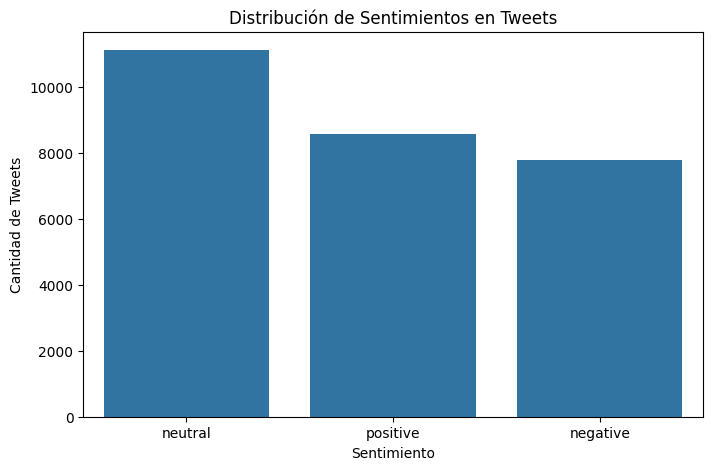


Los datos ya están preprocesados. Saltando limpieza...

=== VISTA PREVIA DEL RESULTADO FINAL ===
                                                    text  \
0                    I`d have responded, if I were going   
1          Sooo SAD I will miss you here in San Diego!!!   
2                              my boss is bullying me...   
3                         what interview! leave me alone   
4       Sons of ****, why couldn`t they put them on t...   
...                                                  ...   
27476   wish we could come see u on Denver  husband l...   
27477   I`ve wondered about rake to.  The client has ...   
27478   Yay good for both of you. Enjoy the break - y...   
27479                         But it was worth it  ****.   
27480     All this flirting going on - The ATG smiles...   

                                          processed_text  
0                                             respond,go  
1                                sooo,sad,miss,san,diego  
2   

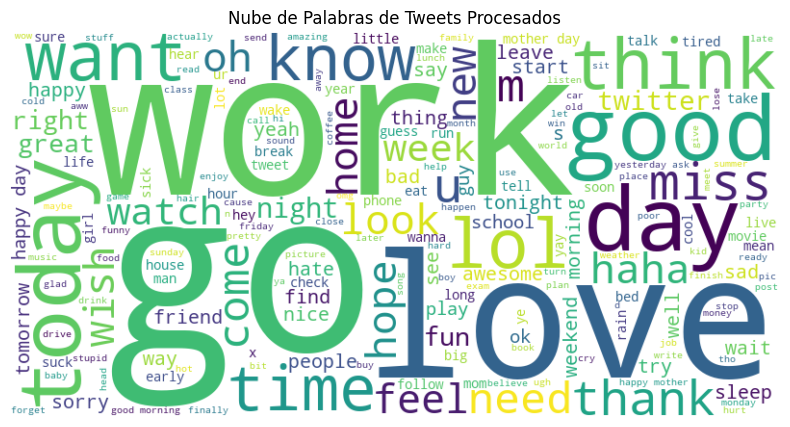

In [1]:
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from tqdm import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt
tqdm.pandas()

#========== Cargar el CSV original o el preprocesado ==========#
if os.path.exists('Tweets_processed.csv'):
    print("Cargando datos preprocesados desde Tweets_processed.csv ...")
    df = pd.read_csv('Tweets_processed.csv', encoding='latin-1')
else:
    print("Cargando Tweets.csv (archivo original)...")
    df = pd.read_csv('Tweets.csv', encoding='latin-1')

#========== Análisis Exploratorio de Datos (EDA) ==========#
print("\n=== ANÁLISIS EXPLORATORIO DE DATOS ===")
print(df.head())
print(df.info())
print("\nConteo de sentimientos:")
print(df['sentiment'].value_counts())  # Columna objetivo (sentimiento)

# Visualizar distribución de sentimientos
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='sentiment', order=df['sentiment'].value_counts().index)
plt.title('Distribución de Sentimientos en Tweets')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad de Tweets')
plt.show()
#===========================================================#

#========== Preprocesamiento de Texto (solo si no existe el CSV procesado) ==========#
if 'processed_text' not in df.columns:
    print("\n🧹 Iniciando limpieza y lematización con spaCy...")
    nlp = spacy.load("en_core_web_sm")

    def clean_text(text):
        if not isinstance(text, str):
            return ""
        doc = nlp(text.lower())  # convierte a minúsculas
        tokens = [
            token.lemma_  # lematiza
            for token in doc
            if token.is_alpha and not token.is_stop  # elimina números, signos y stopwords
        ]
        return ','.join(tokens)  # tokens separados por comas

    start_time = time.time()  # medir tiempo de ejecución
    df['processed_text'] = df['text'].progress_apply(clean_text)
    total_time = time.time() - start_time

    # Guardar el resultado procesado
    df.to_csv('Tweets_processed.csv', index=False, encoding='latin-1')
    print(f"\nPreprocesamiento completado y guardado en 'Tweets_processed.csv' ({len(df)} tweets procesados).")
    print(f"Tiempo total: {total_time:.2f} segundos\n")

else:
    print("\nLos datos ya están preprocesados. Saltando limpieza...")

#========== Mostrar vista previa final ==========#
print("\n=== VISTA PREVIA DEL RESULTADO FINAL ===")
print(df[['text', 'processed_text']])




#=====Mostrar nube de palabras del texto procesado=====#
all_words = ' '.join(df['processed_text'].dropna().tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras de Tweets Procesados')
plt.show()







🚀 Entrenando la red neuronal para clasificar sentimientos...
Epoch 1/25
344/344 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5537 - loss: 0.9327 - val_accuracy: 0.6973 - val_loss: 0.7430
Epoch 2/25
344/344 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7293 - loss: 0.6782 - val_accuracy: 0.6966 - val_loss: 0.7261
Epoch 3/25
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7731 - loss: 0.5869 - val_accuracy: 0.6927 - val_loss: 0.7361
Epoch 4/25
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8029 - loss: 0.5236 - val_accuracy: 0.6786 - val_loss: 0.7640
Epoch 5/25
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8284 - loss: 0.4658 - val_accuracy: 0.6733 - val_loss: 0.8160
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6966 - loss: 0.7261

✅ Precisión final del modelo: 69.66%


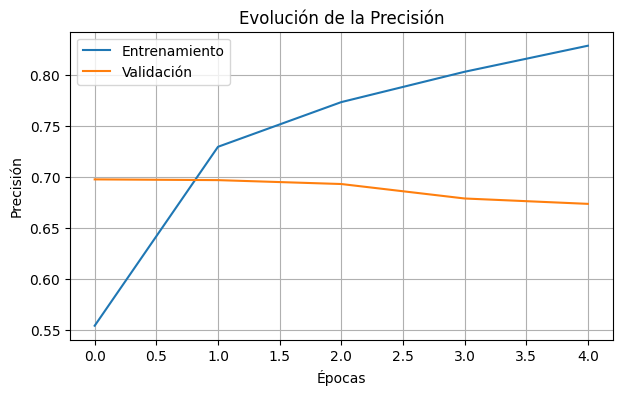

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

#========== 1️⃣ Preparar datos ==========#
# Columnas del CSV se mantienen: 'processed_text' y 'sentiment'
textos_procesados = df['processed_text'].fillna('')  
sentimientos = df['sentiment']

# Convertir sentimientos a números
codificador_sentimientos = LabelEncoder()
sentimientos_codificados = codificador_sentimientos.fit_transform(sentimientos)

# Separar datos en entrenamiento y prueba
textos_entrenamiento, textos_prueba, sentimientos_entrenamiento, sentimientos_prueba = train_test_split(
    textos_procesados, 
    sentimientos_codificados, 
    test_size=0.2, 
    random_state=42, 
    stratify=sentimientos_codificados
)

#========== 2️⃣ Transformación TF-IDF ==========#
objeto_para_extraer_palabras = TfidfVectorizer(
    max_features=5000,        
    ngram_range=(1, 2),       
    sublinear_tf=True
)
matriz_entrenamiento = objeto_para_extraer_palabras.fit_transform(textos_entrenamiento).toarray()
matriz_prueba = objeto_para_extraer_palabras.transform(textos_prueba).toarray()

#========== 3️⃣ Crear modelo de red neuronal ==========
red_neuronal_sentimientos = keras.Sequential([
    layers.Input(shape=(matriz_entrenamiento.shape[1],), name='entrada'),

    layers.Dense(128, activation='relu', name='capa_oculta_1'),
    layers.Dropout(0.3, name='dropout_1'),

    layers.Dense(64, activation='relu', name='capa_oculta_2'),
    layers.Dropout(0.3, name='dropout_2'),

    layers.Dense(len(codificador_sentimientos.classes_), activation='softmax', name='capa_salida')
])

#========== 4️⃣ Compilar modelo ==========
red_neuronal_sentimientos.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#========== 5️⃣ Entrenar modelo ==========
detener_temprano = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print("\n🚀 Entrenando la red neuronal para clasificar sentimientos...")
historial_entrenamiento = red_neuronal_sentimientos.fit(
    matriz_entrenamiento, 
    sentimientos_entrenamiento,
    validation_data=(matriz_prueba, sentimientos_prueba),
    epochs=25,
    batch_size=64,
    callbacks=[detener_temprano],
    verbose=1
)

#========== 6️⃣ Evaluar modelo ==========
perdida_final, precision_final = red_neuronal_sentimientos.evaluate(matriz_prueba, sentimientos_prueba)
print(f"\n✅ Precisión final del modelo: {precision_final * 100:.2f}%")

#========== 7️⃣ Graficar evolución de precisión ==========
plt.figure(figsize=(7,4))
plt.plot(historial_entrenamiento.history['accuracy'], label='Entrenamiento')
plt.plot(historial_entrenamiento.history['val_accuracy'], label='Validación')
plt.title('Evolución de la Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)
plt.show()